# How many transects?

**Adam Steer**

When we go walking around on sea ice to collect observations, a question always in mind is 'how'? How do we get the best representation of the variability present at the site?

A few common strategies exist:

- straight lines
- triangles
- grid transects

...and in the Nansen Legacy sea ice research program we introduced a new approach:

- zigzags

This notebook sets up some tests to see how well a set of straight lines, a triangles, and a zigzag pattern capture the variability present on a site.

### Method

A small sea ice elevation model captured by drone on AeN Q1 is sampled along lines, along triangles, and along zig zag paths at approximately the same interval. Total path length is constrained so that each strategy collects about the same number of observations.

Straight line transects are oriented randomly, and lengths may vary. Triangles are seeded with an initial angle and perimeter length, and randomly oriented. Zigzags are set with an initial angle and track length.

The elevation histogram is computed, and compared to different transect strategies using the two-sample Kolmogorov-Smirnov test.

Whichever strategy achieves greatest similarity for least effort is the winner.

In [1]:
from pyproj import Proj, Transformer, CRS
from osgeo import osr
import time

In [ ]:
!mamba install libgdal -c conda-forge -y

In [2]:
import rioxarray
import shapely.geometry
import pyproj
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from shapely.geometry import Point, LineString

from scipy.stats import ks_2samp



In [4]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

new_viridis = cm.get_cmap('viridis', 1000)

/tmp/ipykernel_21715/3440227682.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  new_viridis = cm.get_cmap('viridis', 1000)


In [5]:
def extract_along_line(xarr, line, n_samples=256):
    profile = []
    points = []

    for i in range(n_samples):
        # get next point on the line
        point = line.interpolate(i / n_samples - 1., normalized=True)
        # access the nearest pixel in the xarray
        #print(point.x)
        #print(point.y)
        value = xarr.sel(x=point.x, y=point.y, method="nearest").data
        #print(value)
        #print(value)
        #print(point)
        #print([x,y])
        profile.append(value)
        points.append([point.x,point.y])
        
    return profile,points


In [6]:
new_viridis.colors[0]

array([0.267004, 0.004874, 0.329415, 1.      ])

### Import a DEM

using `rioxarray` - this gives us a numpy array which can be addressed by XY indexing and also geospatial coordinates

In [8]:
#sample_tif = ('https://elevationeuwest.blob.core.windows.net/copernicus-dem/'
#              'COP30_hh/Copernicus_DSM_COG_10_N35_00_E138_00_DEM.tif')

sample_tif = "/mnt/documents/ANAFI_USA_data/AeN_Q1_2021_P4_10032021/odm/odm_dem/dsm.tif"

#sample_tif = "../../Documents/AeN/q2-workingdata/p4/opendronemap/levelled-dem.tif"
# Load xarray
thetile = rioxarray.open_rasterio(sample_tif, src_nodata=-9999.0, masked = True).squeeze()
# create a line (here its the diagonal of tile)


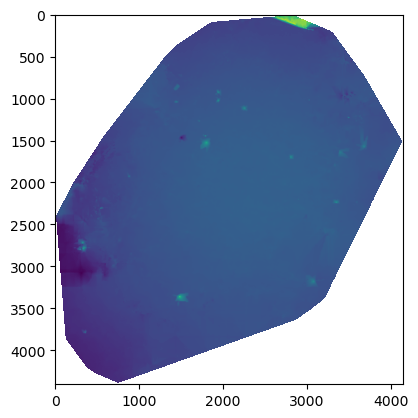

In [9]:
plt.imshow(thetile)

In [38]:
tile = thetile[500:2000, 1500:3000]

In [39]:
makenans = np.where(thetile == -9999)

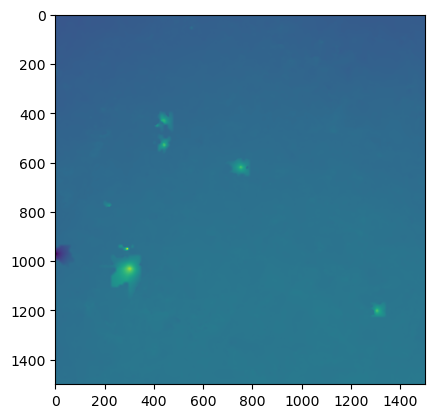

In [40]:
plt.imshow(tile)

In [41]:
tile[makenans] = np.nan

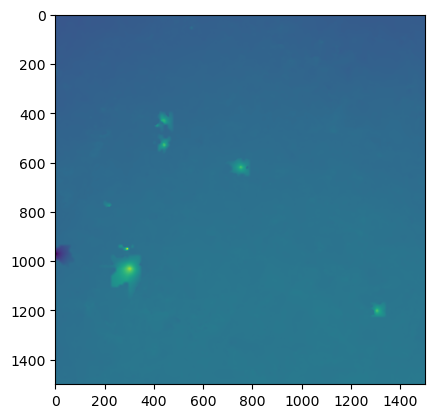

In [42]:
plt.imshow(tile)

### Start computing transect lines

In [43]:
theshape = np.shape(tile)
theshape

(1500, 1500)

In [44]:
#set up 1000 random X points
xtransectcoords = np.random.randint(0,theshape[0]-1, 1000)

In [45]:
# and 1000 random y points
ytransectcoords = np.random.randint(0,theshape[1]-1, 1000)

In [46]:
# set up some random endpoints
ymatrix = np.random.randint(2, size=1000)
xmatrix = np.random.randint(2, size=1000)

In [47]:
yminmax = [y+theshape[0]-2 if y != 0 else 0 for y in ymatrix]
xminmax = [x+theshape[0]-2 if x != 0 else 0 for x in xmatrix]

(0.0, 2000.0)

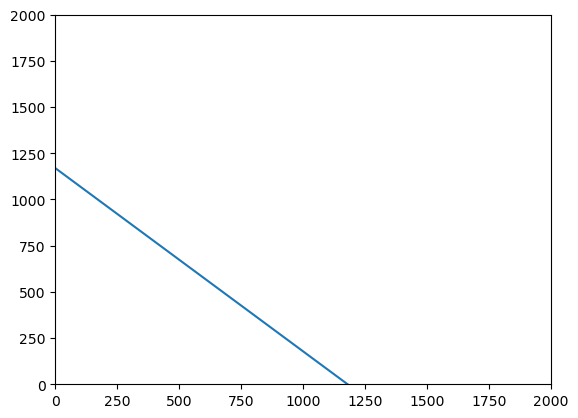

In [48]:
plt.plot((xtransectcoords[18], 0), (0, ytransectcoords[18]))
plt.xlim(0,2000)
plt.ylim(0,2000)

In [49]:
xpairs = list(zip(np.ravel(xtransectcoords), np.ravel(yminmax)))

In [50]:
ypairs = list(zip(np.ravel(xminmax),np.ravel(ytransectcoords)))

In [51]:
xpairs[0]

(994, 0)

In [52]:
ypairs[0]

(1499, 1266)

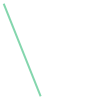

In [53]:
# test shapely line generation - in geospatial space

line = shapely.geometry.MultiLineString([[
            [tile.x[xpairs[0][0]],tile.y[xpairs[0][1]]],
            [tile.x[ypairs[0][0]], tile.y[ypairs[0][1]]]]])

line

In [54]:
line.is_valid

True

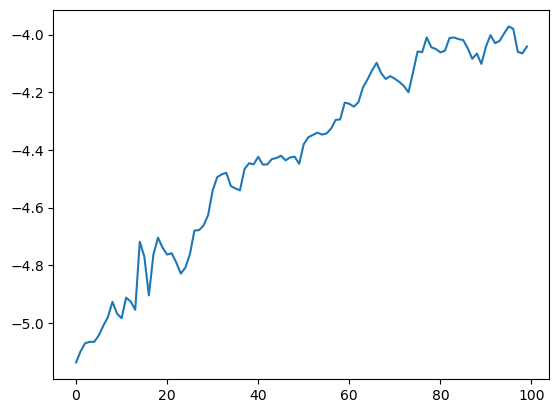

In [55]:
# test data extraction from the DEM
line_profile, line_points = extract_along_line(tile, line, 100)
plt.plot(line_profile)

### Start setting up triangles

In [56]:
def rotate(point, angle):
    angle = angle * (np.pi/180)
    rsin = np.sin(angle)
    rcos = np.cos(angle)

    x = point[0]
    y = point[1]
    x = x * rcos - y * rsin
    y = x * rsin + y * rcos

    return [x,y]

In [64]:
#placeholder function, to be filled when all the manual stuff is worked out

def local_triangle_generator(perimeter, xmax, ymax):
    # given a perimeter length and some coord limits, compute some triangles.
    # return a shapely multi-line that we can extract points along
    
    #provide a ground sample distance in meters.
    
    
    # always make isocoles' triangles for now. Angle 1 is 45 to 75 degrees
    main_angle = np.random.randint(45,75,1)
    
    #other two angles are equal
    other_angles = (180 - main_angle)/2
    
    #get length of triangle sides
    k = perimeter/(np.sin(main_angle) + np.sin(other_angles) + np.sin(other_angles) )
    
    print(k)
    opp = k*(np.sin(main_angle))
    adj = k*(np.sin(other_angles))
    
    # a start point, lets set it to X = 0 Y = halfway
    start_point = [0, int(ymax/2)]
    
    # make a triangle
    # now we have the side length, work out coordinates of corners, from our start point

    corner_1_y = start_point[1] + opp/2
    corner_2_y = start_point[1] - opp/2

    # work out X from right angle rules

    x_dist = np.sqrt(adj**2 - (opp/2)**2)

    corner_1_x = start_point[0] + x_dist
    corner_2_x = corner_1_x

    corner_1 = [int(np.floor(corner_1_x)), int(np.floor(corner_1_y))]
    corner_2 = [int(np.floor(corner_2_x)), int(np.floor(corner_2_y))]
    
    # rotate a triangle randomly
    
    #translate so that the rotation is about 0, 0
    
    start_point_t = [-x_dist/2, 0]
    corner_1_t = [x_dist/2, opp/2]
    corner_2_t = [x_dist/2, -opp/2]
    
    
    # rotate
    rotation_angle = np.random.randint(0,359,1)
    start_point_r = rotate(start_point_t, rotation_angle)
    corner_1_r = rotate(corner_1_t, rotation_angle)
    corner_2_r = rotate(corner_2_t, rotation_angle)
    
    
    #translate into the bounding box of the DEM tile
    # x and y havd to sit between (0, tilemax)
    
    
    
    
    # prepare something to return!
    triangle_local = shapely.geometry.LineString([[start_point_r[0], start_point_r[1]],
                  [corner_1_r[0], corner_1_r[1]],
                  [corner_2_r[0], corner_2_r[1]],
                  [start_point_r[0], start_point_r[1]]
                  ])

    print(triangle_local.length)
    
    return triangle_local
    
    

In [65]:
triangle = local_triangle_generator(500, 1500, 1500)

[187.91626846]
416.7433086775069


In [66]:
triangle.coords.xy

(array('d', [-65.43606309243097, 107.57354786907139, 23.29857831579055, -65.43606309243097]),
 array('d', [43.78527257477483, -25.182335377443934, -62.38820977210573, 43.78527257477483]))

In [67]:
# declare a triangle by hand  for testing

# perimeter is scaled by the image resolution - here, 10cm. 

perimeter = 400 / 0.1
start_point = [200,800]
main_angle = 60.0 * (np.pi/180)
other_angles = ((180-main_angle)/2) * np.pi/180

# using the law of sines, compute the ratio of angles to sides
# from https://math.stackexchange.com/questions/2396857/determining-the-sides-of-a-triangle-given-are-perimeter-and-three-angles

k = perimeter/(np.sin(main_angle) + np.sin(other_angles) + np.sin(other_angles) )

opp = k*(np.sin(main_angle))
adj = k*(np.sin(other_angles))

# now we have the side length, work out coordinates of corners, from our start point

corner_1_y = start_point[1] + opp/2
corner_2_y = start_point[1] - opp/2

# work out X from right angle rules

x_dist = np.sqrt(adj**2 - (opp/2)**2)

corner_1_x = start_point[0] + x_dist
corner_2_x = corner_1_x

corner_1 = [int(np.floor(corner_1_x)), int(np.floor(corner_1_y))]
corner_2 = [int(np.floor(corner_2_x)), int(np.floor(corner_2_y))]

print(corner_1)
print(corner_2)




#line = shapely.geometry.MultiLineString([[
#            [tile.x[xpairs[0][0]],tile.y[xpairs[0][1]]],
#            [tile.x[ypairs[0][0]], tile.y[ypairs[0][1]]]]])

triangle_local = shapely.geometry.LineString([[start_point[0], start_point[1]],
                  [corner_1[0], corner_1[1]],
                  [corner_2[0], corner_2[1]],
                  [start_point[0], start_point[1]]
                  ])

triangle_geo = shapely.geometry.LineString([ [tile.x[start_point[0]], tile.y[start_point[1]]],
                                              [tile.x[corner_1[0]], tile.y[corner_1[1]]], 
                                              [tile.x[corner_2[0]], tile.y[corner_2[1]]], 
                                              [tile.x[start_point[0]], tile.y[start_point[1]]] ])

#triangle_test2 = LineString((start_point[0], start_point[1]), (corner_1_x, corner_1_y), (corner_2_x, corner_2_y),(start_point[0], start_point[1]))

[1458, 1404]
[1458, 195]


In [68]:
triangle_geo.xy

(array('d', [512738.05500000005, 512800.9550000001, 512800.9550000001, 512738.05500000005]),
 array('d', [8855999.895, 8855969.694999998, 8856030.145, 8855999.895]))

In [69]:
triangle_geo.length

200.0202136255672

In [70]:
triangle_geo.is_valid

True

In [74]:
tri_profile, tri_points = extract_along_line(tile, triangle_geo, 400)

In [ ]:
tri_bins=

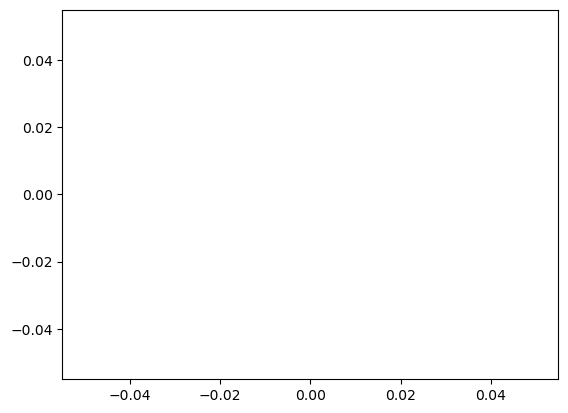

In [76]:
this = plt.hist(np.ravel(tile), density = True, histtype="bar", bins = tri_bins, label="tile")
this = tile.sel(x=500, y=1000, method="nearest").data

In [77]:
this

array(-4.1499085, dtype=float32)

In [78]:
tri_points = np.squeeze(tri_points)

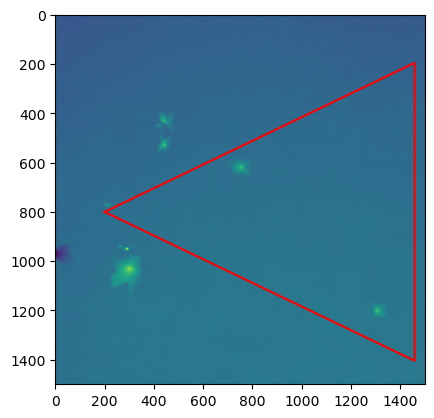

In [80]:
#plot the triangle

plt.imshow(tile)
                            
x,y = triangle_local.xy
plt.plot(x,y, c='red')
#plt.scatter(tri_points[:,0], tri_points[:,1])

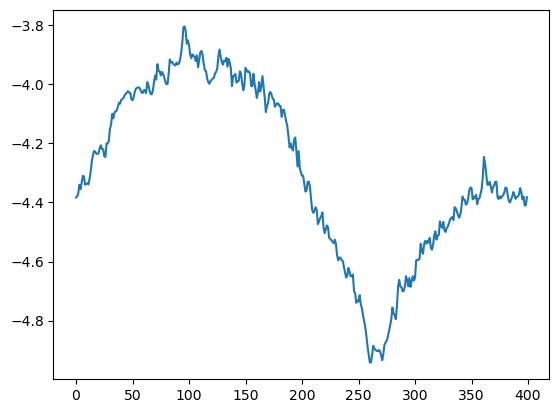

In [81]:
plt.plot(tri_profile)

In [102]:
tri_bins = np.arange(0, max(np.ravel(tile)), 0.01)

(array([21., 15., 28., 38., 68., 47., 26., 39., 93., 25.]),
 array([-4.94199991, -4.82819991, -4.71439991, -4.60059991, -4.48679991,
        -4.37299991, -4.25919991, -4.1453999 , -4.0315999 , -3.9177999 ,
        -3.8039999 ]),
 <BarContainer object of 10 artists>)

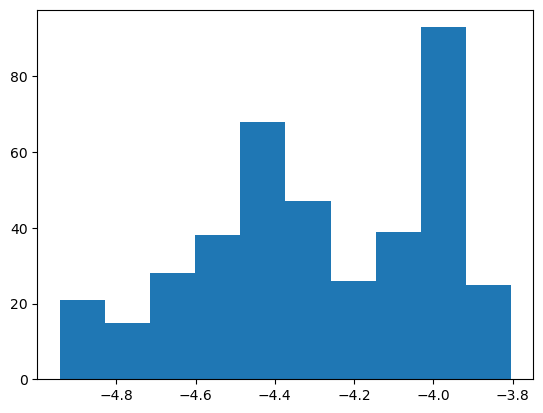

In [103]:
plt.hist(tri_profile)

(array([1.870000e+02, 9.490000e+02, 1.088540e+05, 1.996707e+06,
        1.319630e+05, 8.155000e+03, 2.444000e+03, 6.030000e+02,
        1.210000e+02, 1.700000e+01]),
 array([-8.69315052, -7.49855375, -6.30395651, -5.10935974, -3.9147625 ,
        -2.72016573, -1.5255686 , -0.33097166,  0.86362535,  2.05822229,
         3.2528193 ]),
 <BarContainer object of 10 artists>)

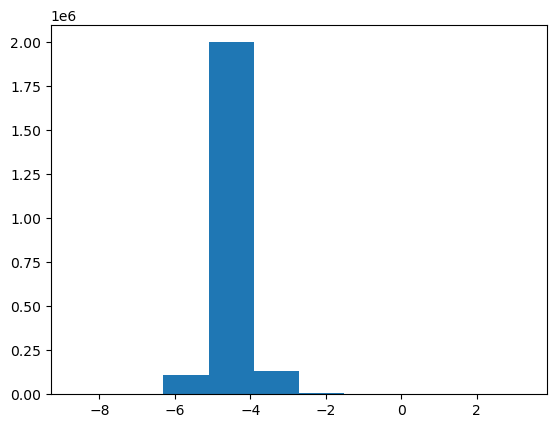

In [95]:
plt.hist(np.squeeze(np.ravel(tile)))

In [96]:
tri_profile = [float(a) for a in tri_profile]

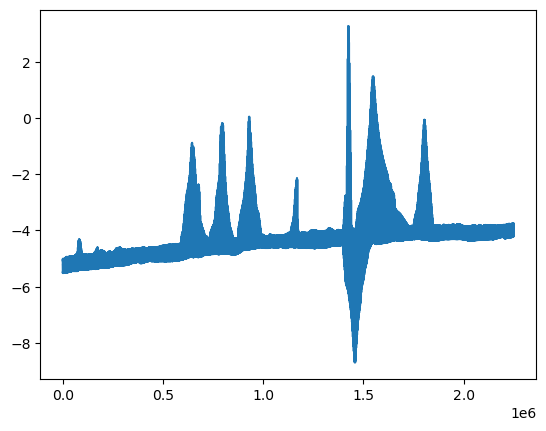

In [97]:
plt.plot(np.ravel(tile))

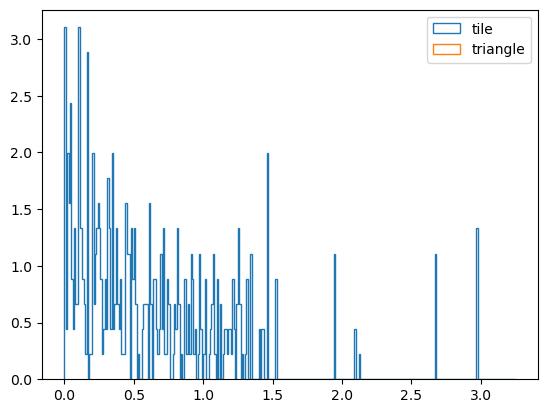

In [101]:
this = plt.hist(np.squeeze(np.ravel(tile)), density = True, histtype="step", bins = tri_bins, label="tile")
this = plt.hist(tri_profile, density = True, histtype="step", bins = tri_bins, label="triangle")
plt.legend()

In [104]:
np.sin(other_angles)

0.9999582439930004

In [105]:
other_angles

1.5616578042012952

In [106]:
10 / np.sin(45)

11.752213631357492

In [107]:
100/np.sin(45)

117.5221363135749

In [108]:
## next make a zigzag

def local_zigzag(length, angle, xmax, ymax,  max_leg=100 ):
    
    #make a zigzag pattern up to a given length, with fixed angles, and a max leg length
    
    #start at 0,0 for simplicity
    
    turn_points_x = []
    turn_points_y = []
    
    start_x = 0
    start_y = 0
    
    #find out how many full legs to draw
    the_legs = np.divmod(length, max_leg)
    n_legs = the_legs[0]
    #are there any part legs? find any part leg length
    # as a proportion of the leg length
    if the_legs[1] < 0:
        part_leg_length = (the_legs[1]/max_leg)

    
    start_angle = (0.5 * angle) * np.pi/180
    
    # using the right angle triangle rule, figure out a coordinate for the first turning point.
    # we will always walk in positive Y,
    # X coord is adjacent side, Y coord is opposite side length. hypotenuse is max_leg
    
    i = 0
    
    turn_points_x.append(0)
    turn_points_y.append(0)

    
    while i <= n_legs:
        if i == 0:
        
            y_1 = np.sin(start_angle) * max_leg
            x_1 = np.cos(start_angle) * max_leg
            turn_points_x.append(x_1)
            turn_points_y.append(y_1)
            print(x_1, y_1)                                 
        
        if ((i > 0) & (i%2!=0)):
            # odd numbers, walk back to 0
            turn_points_x.append(0)
            turn_points_y.append((i+1)*y_1)
        
        if ((i > 0) & (i%2==0)):
            # even numbers, positive X
            turn_points_x.append(x_1)
            turn_points_y.append((i+1)*y_1)
        
        i += 1
    
    print(turn_points_x)
    
    #x_diff = xmax - max(turn_points_x)
    #turn_points_x = turn_points_x + (x_diff /2)
    
    #y_diff = ymax - max(turn_points_y)
    #turn_points_y = turn_points_y - (y_diff /2)
    
    
    # thats it for trig, unless we want to jiggle the angle a bit. For now lets keep it simple.
    # Y coord for the next point is (firsint(t Y *2). X coord is 0
    # Y coord for next point is (first y * 3), X is same as X1... and so on
    
    turn_points = list(zip(turn_points_x, turn_points_y))
    
    
    # using the right rule with a reversed X axis sign
    
    return turn_points
    


In [121]:
this = local_zigzag(400 / 0.1, 35, 1500, 1500, max_leg=1500)

1430.5754261223403 451.0586992564097
[0, 1430.5754261223403, 0, 1430.5754261223403]


In [122]:
this

[(0, 0),
 (1430.5754261223403, 451.0586992564097),
 (0, 902.1173985128194),
 (1430.5754261223403, 1353.176097769229)]

In [123]:
### Automate generating these!!!

zigzag_local = shapely.geometry.LineString([
                  [int(this[0][0]), int(this[0][1])],
                  [int(this[1][0]), int(this[1][1])], 
                  [int(this[2][0]), int(this[2][1])], 
                  [int(this[3][0]), int(this[3][1])]
                  ]) 


zigzag_geo = shapely.geometry.LineString([ [tile.x[int(this[0][0])], tile.y[int(this[0][1])]],
                                           [tile.x[int(this[1][0])], tile.y[int(this[1][1])]], 
                                           [tile.x[int(this[2][0])], tile.y[int(this[2][1])]], 
                                           [tile.x[int(this[3][0])], tile.y[int(this[3][1])]]                                      
                                         ])

In [124]:
zigzag_local.length

4498.300679145404

In [125]:
triangle_local.length

4000.404272478479

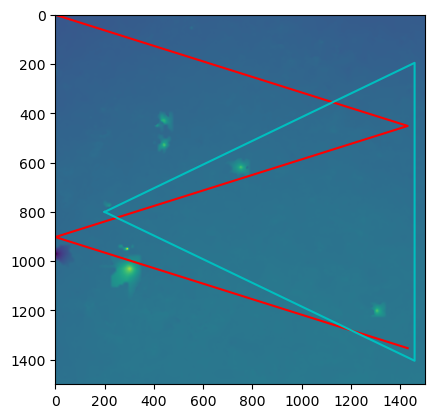

In [126]:
plt.imshow(tile)
z_x,z_y = zigzag_local.xy
plt.plot(z_x,z_y, c = 'r')
t_x,t_y = triangle_local.xy
plt.plot(t_x,t_y, c = 'c')

In [127]:
zigzag_profile, zigzag_points = extract_along_line(tile, zigzag_geo, 450)

In [128]:

# use the method from above to extract the profile
profile2, points2 = extract_along_line(tile, line)

In [129]:
line.length

68.20689114810284

In [130]:
profiles = []
i = 0
total_samples = []
for coord in xpairs[0:5]:
    #print("coords: [{}, {}], [{}, {}]".format(coord[0], coord[1],ypairs[i][0],ypairs[i][1] ))
    
    line = shapely.geometry.MultiLineString([[
            [tile.x[coord[0]],tile.y[coord[1]]],
            [tile.x[ypairs[i][0]], tile.y[ypairs[i][1]]]]])

    # sample every 'meter'
    n_samples = (int(np.floor(line.length)))
    
    # use the method from above to extract the profile
    profile, points = extract_along_line(tile, line, n_samples)
    profiles.append(profile),
    total_samples.append(n_samples)
    if sum(total_samples) > 400:
        break
    i+=1
    

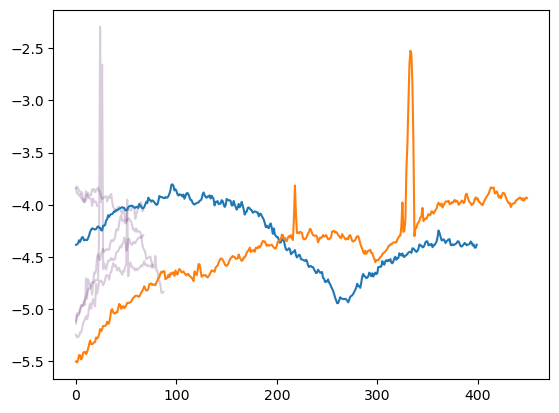

In [131]:
#plot the profiles

i=0
mega_profile = []

for profile in profiles:
    plt.plot(profile, c=new_viridis.colors[i], alpha=0.2)
    unpacked_profile = [float(x) for x in profile]
    mega_profile.extend(unpacked_profile)
    
    i+=1
    
plt.plot(tri_profile)
plt.plot(np.ravel(zigzag_profile))

In [132]:
transect_test = ks_2samp(np.ravel(tile), np.ravel(mega_profile))
    
transect_test_p = np.round(transect_test.pvalue,2)
transect_test_stat = np.round(transect_test.statistic, 2)


tri_test = ks_2samp(np.ravel(tile), tri_profile)
    
tri_test_p = np.round(tri_test.pvalue,2)
tri_test_stat = np.round(tri_test.statistic, 2)

zig_test = ks_2samp(np.ravel(tile), zigzag_profile)
    
zig_test_p = np.round(zig_test.pvalue,2)
zig_test_stat = np.round(zig_test.statistic, 2)




In [134]:
inches = 2.51

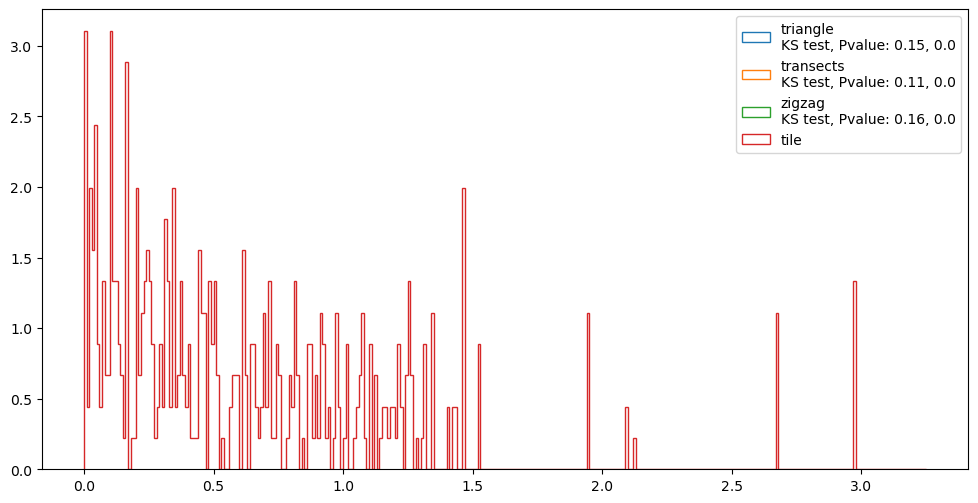

In [135]:
fig = plt.figure(figsize = (30/inches,15/inches))


this = plt.hist(tri_profile, density = True, histtype="step", bins = tri_bins,
                label=("triangle" + "\nKS test, Pvalue: "+str(tri_test_stat)+", "+str(tri_test_p)))
this = plt.hist(mega_profile, density = True, histtype="step", bins = tri_bins,
                label=("transects" + "\nKS test, Pvalue: "+str(transect_test_stat)+", "+str(transect_test_p)))
this = plt.hist(zigzag_profile, density = True, histtype="step", bins = tri_bins,
                label=("zigzag" + "\nKS test, Pvalue: "+str(zig_test_stat)+", "+str(zig_test_p)))
this = plt.hist(np.ravel(tile), density = True, histtype="step", bins = tri_bins, label="tile")

plt.legend()

In [136]:
sum(total_samples)

323

In [137]:
min(np.ravel(tile))

-8.6931505

In [138]:
max(np.ravel(tile))

3.2528193

In [139]:
from scipy import stats

In [140]:
raveltile = np.ravel(tile)

In [141]:
thebins = np.arange(min(np.ravel(tile)), max(np.ravel(tile)), 0.01)

## Plot a lot of transects

this section is used to plot a lot of transects, and make frames for a video showing how the captured distribution evolves.

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

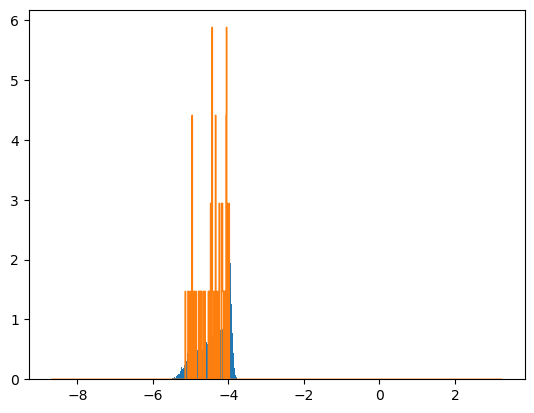

In [145]:
#weights = np.ones_like(raveltile)/float(len(raveltile))
theprofile = []
i = 0


n, x, _  = plt.hist(np.ravel(tile), thebins, density = True)

for profile in profiles:
    
    unpacked_profile = [float(x) for x in profile]
    
    theprofile.append(unpacked_profile)

    #boop = stats.gaussian_kde(np.ravel(theprofile))
    #plt.plot(boop(x), label=i)
    
    n1, x1, _  = plt.hist(np.ravel(theprofile), thebins, density = True, histtype = "step")
    
    #plt.legend()
    #time.sleep(2)
    
    i+=1

In [146]:
inches = 2.51

In [147]:
color_order = np.random.randint(0,999,1000)

In [148]:
len(profiles)

5

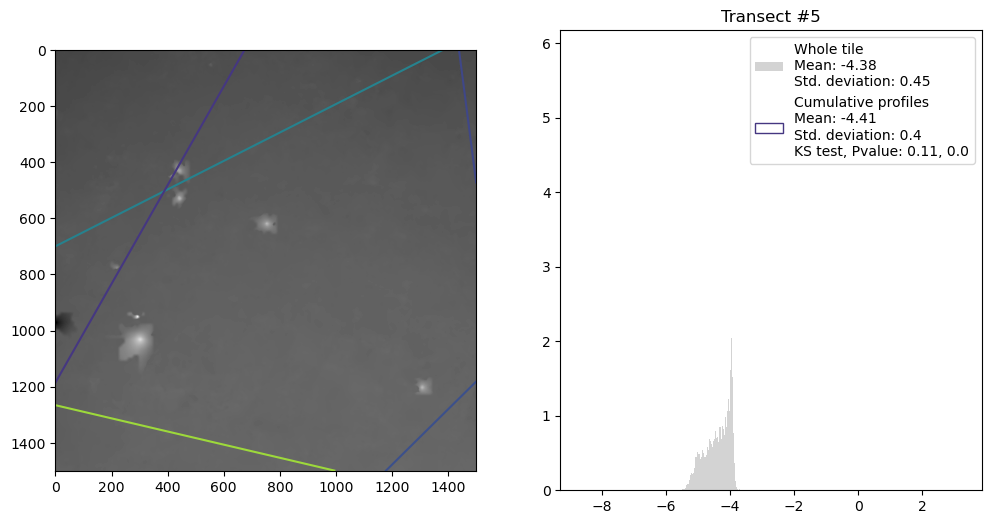

In [152]:
fig = plt.figure(figsize = (30/inches,15/inches))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

tilestats = stats.describe(np.ravel(tile))

ax1.imshow(tile, cmap="gray")
n, x, _  = ax2.hist(np.ravel(tile), thebins, density = True, facecolor="lightgray",
                    label = "Whole tile\nMean: "+str(np.round(np.nanmean(raveltile),2))+"\nStd. deviation: "+str(np.round(np.nanstd(raveltile),2)))


mega_profile = []
i=0


for profile in profiles:
    
    unpacked_profile = [float(x) for x in profile]
    
    #print(unpacked_profile)
    
    #print(np.shape(unpacked_profile))
    
    mega_profile.extend(unpacked_profile)
    
    #print(np.shape(mega_profile))
    
    #profilestats = stats.describe(mega_profile)

    ax1.plot([xpairs[i][0], xpairs[i][1]], [ypairs[i][0], ypairs[i][1]], c = new_viridis.colors[color_order[i]])

    #single_profile = [x/100 if x > 0 else 0 for x in unpacked_profile]
    #n1, x1, bars  = ax2.hist(single_profile, thebins/100, density = True, histtype="step", edgecolor="gray",
    #                         label = "Profile #"+str(i))
    
    #for b in bars:
    #    b.set_height(b.get_height()/2)
    
    hist_test = ks_2samp(raveltile, np.ravel(mega_profile))
    
    hist_test_p = np.round(hist_test.pvalue,2)
    hist_test_stat = np.round(hist_test.statistic, 2)
    
    n1, x1, bars1  = ax2.hist(np.ravel(mega_profile), thebins, density = True, histtype="step", edgecolor=new_viridis.colors[color_order[i]],
                             label = ("Cumulative profiles\nMean: "+str(np.round(np.nanmean(mega_profile),2))+" "
                                      "\nStd. deviation: "+str(np.round(np.nanstd(mega_profile),2))+" "
                                      "\nKS test, Pvalue: "+str(hist_test_stat)+", "+str(hist_test_p)
                                     )
                             )
    
    ax2.legend()
    plt.title("Transect #"+str(i+1))
    
    seqnumber = str(i)
    
    if len(seqnumber) == 1:
        seqnumber = "00"+seqnumber
    if len(seqnumber) == 2:
        seqnumber = "0"+seqnumber
    
    plt.savefig("./howmanytransects/"+seqnumber+"seaice_.jpg")
    
    #_ = [b.remove() for b in bars]
    _ = [b.remove() for b in bars1]

    
    i+=1


In [153]:

ks_2samp(raveltile, np.ravel(profile))

KstestResult(statistic=0.42466679738562096, pvalue=1.2143518725889034e-11, statistic_location=-4.276439, statistic_sign=-1)

In [154]:
tilestats = stats.describe(np.ravel(tile))

In [155]:
np.sqrt(tilestats.mean)

/tmp/ipykernel_21715/2170113225.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(tilestats.mean)


nan

In [156]:
stats.describe(np.ravel(mega_profile))

DescribeResult(nobs=323, minmax=(-5.271041393280029, -2.2924704551696777), mean=-4.411452208510124, variance=0.16315514626015548, skewness=0.5048638434792121, kurtosis=2.0133836697660374)

In [161]:
theprofile[1]

array([-3.83825827, -3.82401371, -3.84152651, -3.86812782, -3.87101007,
       -3.89600015, -3.88082004, -3.96000004, -3.9490242 , -3.97322631,
       -3.95362735, -3.9000001 , -3.93600011, -3.93677759, -3.93900061,
       -3.94375753, -4.01073933, -3.94000006, -3.97399998, -3.97000003,
       -3.97399998, -4.01000023])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

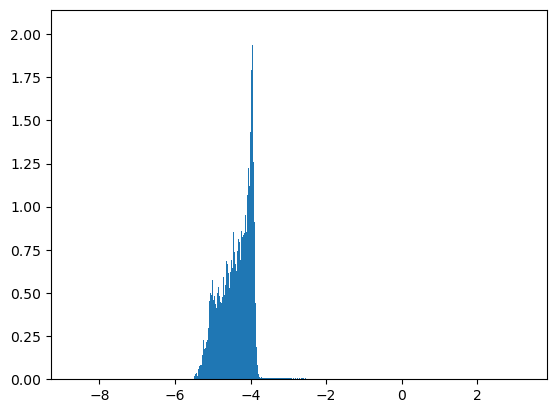

In [158]:
n, x, _  = plt.hist(np.ravel(tile), thebins, density = True)

n1, x1, _  = plt.hist(np.ravel(theprofile), thebins, density = True)